In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import utils
import skutils
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

seed = 47

# Use ggplot style
plt.style.use('ggplot')

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [35]:
big = train.append(test)
big.shape

big.species = big.species.astype('category')
big.species = big.species.cat.codes

# big = pd.get_dummies(big, sparse=True)

In [36]:
def transform(data):
    ID = data.id
    X = data.drop(['species', 'id'], axis=1)
    y = data['species']
    return ID, X, y

ID, X, y = transform(big)

In [37]:
def addZeroColumn(df, colName):
    df.loc[df[colName] < 0.01, colName + '_is_small'] = 1
    df[colName + '_is_small'].fillna(0, inplace=True)

def addZeroColumns(df, colBaseName):
    for n in range(1,65):
        addZeroColumn(df, colBaseName + str(n))
        
addZeroColumns(X, 'margin')
addZeroColumns(X, 'texture')

In [ ]:
classifiers = {
        "LR": { "f": LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1) },
        "LR_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "LR_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
        "RF_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_mm": { "f": Pipeline([
                    ('scaling', MinMaxScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) },
        "RF_rob": { "f": Pipeline([
                    ('scaling', RobustScaler()),
                    ('estimator', RandomForestClassifier(n_estimators=100, n_jobs=-1))
                ]) }
    }  

In [ ]:
def test_split(test_size):
    sss = StratifiedShuffleSplit(10, test_size=0.3, random_state=seed)

    from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, cohen_kappa_score, auc, make_scorer, average_precision_score, f1_score
    from sklearn.pipeline import Pipeline

    classifiers = {
        "LR_std": { "f": Pipeline([
                    ('scaling', StandardScaler()),
                    ('estimator', LogisticRegression(solver='lbfgs', multi_class='multinomial', n_jobs=-1))
                ]) },
        "RF": { "f": RandomForestClassifier(n_estimators=100, n_jobs=-1) },
    }   

    measures = {
        'pre': precision_score,
        #'avg': average_precision_score,
        'rec': recall_score,
        'acc': accuracy_score,
        'ck': cohen_kappa_score,
        'f1': f1_score
    }

    for clf in classifiers.keys(): 
        c = classifiers[clf]   
        for meas in measures.keys():
            c[meas] = []

    for train_index, test_index in sss.split(X, y):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        for clf in classifiers.keys():                    
            c = classifiers[clf]    
            c["f"].fit(X_train, y_train)
            y_pred = c["f"].predict(X_test)
            #print(classification_report(y_test, y_pred))

            for meas in measures.keys():
                m = measures[meas]

                if (meas != 'ck' and meas != 'acc'):
                    score = m(y_test, y_pred, average='micro')
                else:
                    score = m(y_test, y_pred)

                c[meas].append(score);
    
    return classifiers
               
cl = []
    
for i in range(0,9):
    cl.append(test_split(0.1 + 0.1 * i))

In [ ]:
classifiers

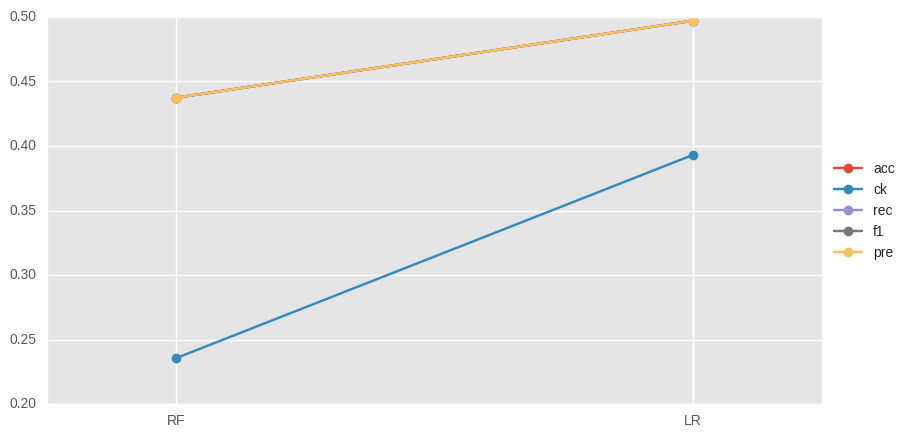

In [119]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(0,10):
    results = pd.DataFrame(columns=measures.keys())

    # Evaluate each model in classifiers
    for model in classifiers.keys():
        results.loc[model] = [np.mean(cl[i][model][measure]) for measure in measures.keys()]

    figsize(10, 5)
    ax = plt.subplot(111)

    ind = np.arange(results.shape[0])
    width = 0.2
    l = ax.plot(ind, results, "-o")
    plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([-0.25, ind[-1]+.25])
    ax.set_xticks(ind)
    ax.set_xticklabels(results.index)
    plt.show()

In [ ]:
X = StandardScaler().fit(X).transform(X)

In [ ]:
big.columns

In [ ]:
X[]